<a href="https://colab.research.google.com/github/marlonrcfranco/soyforecast/blob/master/soyforecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soyforecast
By [Marlon Franco]()
/ [GitHub](https://github.com/marlonrcfranco/soyforecast.git)

####Prediction of future soybeans stock prices on the Chicago Stock Exchange (CBOT) using a LSTM model and relating climatic data from the most productive regions of the USA.

![alt text](https://github.com/marlonrcfranco/soyforecast/blob/master/Selection_244.png?raw=true)


## Soybean, CBOT Soybean Futures + ( Global Historical Climatology Network (GHCN) filtered by USDA-NASS-soybeans-production_bushels-2015)

### Soybean, CBOT Soybean Futures
- *https://blog.quandl.com/api-for-commodity-data*
- *http://www.quandl.com/api/v3/datasets/CHRIS/CME_S1/*

### Global Historical Climatology Network (GHCN)
- *https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/global-historical-climatology-network-ghcn*
- *FTP: ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/*


- **TMAX** = Maximum temperature (tenths of degrees C)
- **TMIN** = Minimum temperature (tenths of degrees C)
- **TAVG** = Average temperature (tenths of degrees C)
```
(Note that TAVG from source 'S' corresponds to an average for the period ending at 2400 UTC rather than local midnight )
```
- **PRCP** = Precipitation (tenths of mm)

### USDA-NASS-soybeans-production_bushels-2015
- *https://usda-reports.nautilytics.com/?crop=soybeans&statistic=production_dollars&year=2007*
- *https://www.nass.usda.gov/Data_Visualization/index.php*


****

*Based on the tutorial: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/*


## Imports

In [0]:
%matplotlib inline
import os
from six.moves import urllib

from math import sqrt
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import model_from_json

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau



In [1122]:
tf.__version__

'1.14.0-rc1'

In [1123]:
tf.keras.__version__

'2.2.4-tf'

## Defines

In [0]:
DATASETMARLON_URL = "https://raw.githubusercontent.com/marlonrcfranco/soyforecast/master/datasets/DatasetMarlon/datasetMarlon.csv"
DATASETMARLON_PATH = "datasets/DatasetMarlon/"
MODEL_PATH = "model/"
SETTLE_id = 5
TARGET_NAME = 'Settle'

EPOCHS = 100
BATCH_SIZE = 77
TRAIN_SPLIT = 0.87
LOSS_FUNCTION = 'mse' # mse: Mean Square Error, mae: Mean Absolute Error
NEURONS = 50

default = pyplot.rcParams["figure.figsize"]
pyplot.rcParams["figure.figsize"] = [10,15]

## Fetch Data



In [0]:
def fetch_datasetMarlon_data(datasetmarlon_url=DATASETMARLON_URL, datasetmarlon_path=DATASETMARLON_PATH):
    if not os.path.isdir(datasetmarlon_path):
        os.makedirs(datasetmarlon_path)
    csv_path = os.path.join(datasetmarlon_path, "datasetMarlon.csv")
    urllib.request.urlretrieve(datasetmarlon_url, csv_path)

In [0]:
fetch_datasetMarlon_data()

## Convert series to supervised learning


In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


## Load Data


In [0]:
def load_datasetMarlon_data(datasetmarlon_path=DATASETMARLON_PATH):
    csv_path = os.path.join(datasetmarlon_path, "datasetMarlon.csv")
    print(csv_path)
    return read_csv(csv_path,index_col=['Date','YEAR','MONTH','DAY'])
 

In [1129]:
dataset = load_datasetMarlon_data()
values = dataset.values
print(dataset.shape)
dataset.head(1)

datasets/DatasetMarlon/datasetMarlon.csv
(15062, 256)


,,,,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,TX_TMAX_MEAN,TX_TMAX_STD,TX_TMIN_MEAN,TX_TMIN_STD,TX_TAVG_MEAN,TX_TAVG_STD,TX_PRCP_MEAN,TX_PRCP_STD,NC_TMAX_MEAN,NC_TMAX_STD,NC_TMIN_MEAN,NC_TMIN_STD,NC_TAVG_MEAN,NC_TAVG_STD,NC_PRCP_MEAN,NC_PRCP_STD,NE_TMAX_MEAN,NE_TMAX_STD,NE_TMIN_MEAN,NE_TMIN_STD,NE_TAVG_MEAN,NE_TAVG_STD,NE_PRCP_MEAN,NE_PRCP_STD,KS_TMAX_MEAN,KS_TMAX_STD,KS_TMIN_MEAN,KS_TMIN_STD,KS_TAVG_MEAN,KS_TAVG_STD,KS_PRCP_MEAN,KS_PRCP_STD,...,MS_TMAX_MEAN,MS_TMAX_STD,MS_TMIN_MEAN,MS_TMIN_STD,MS_TAVG_MEAN,MS_TAVG_STD,MS_PRCP_MEAN,MS_PRCP_STD,ND_TMAX_MEAN,ND_TMAX_STD,ND_TMIN_MEAN,ND_TMIN_STD,ND_TAVG_MEAN,ND_TAVG_STD,ND_PRCP_MEAN,ND_PRCP_STD,WV_TMAX_MEAN,WV_TMAX_STD,WV_TMIN_MEAN,WV_TMIN_STD,WV_TAVG_MEAN,WV_TAVG_STD,WV_PRCP_MEAN,WV_PRCP_STD,DE_TMAX_MEAN,DE_TMAX_STD,DE_TMIN_MEAN,DE_TMIN_STD,DE_TAVG_MEAN,DE_TAVG_STD,DE_PRCP_MEAN,DE_PRCP_STD,IA_TMAX_MEAN,IA_TMAX_STD,IA_TMIN_MEAN,IA_TMIN_STD,IA_TAVG_MEAN,IA_TAVG_STD,IA_PRCP_MEAN,IA_PRCP_STD
Date,YEAR,MONTH,DAY,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-04-22,2019,4,22,881.5,883.25,876.25,876.75,3.5,877.0,62527.0,205572.0,72.62779,566.42426,44.583332,354.48105,18.318048,317.19855,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plot columns from CBOT dataset

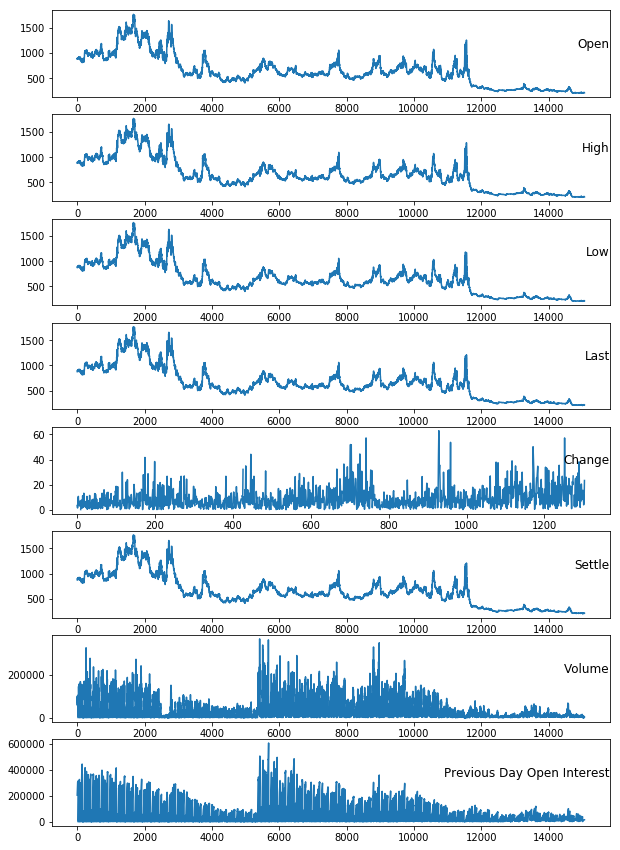

In [1130]:
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

## Plot columns from GHCN dataset (filtered by the state of Texas)



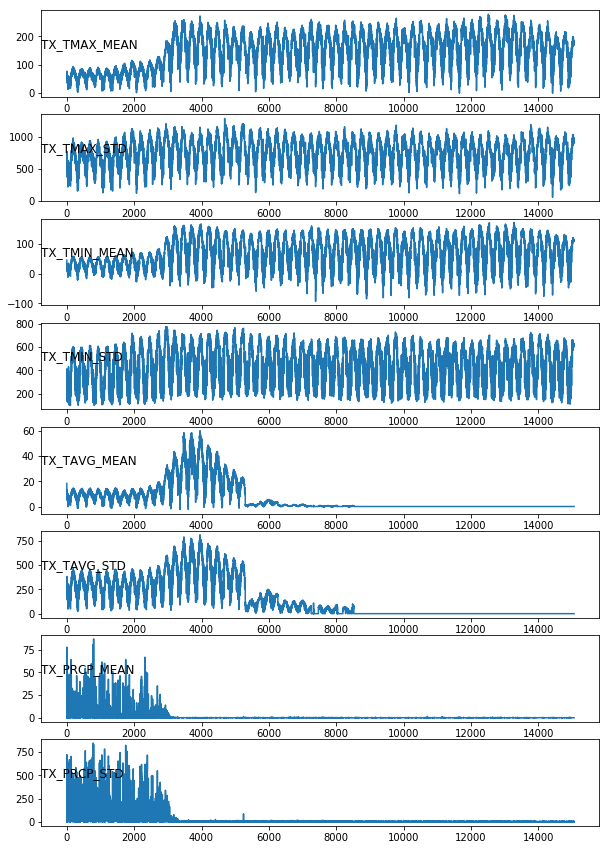

In [1131]:
# specify columns to plot
groups = [8,9,10,11,12,13,14,15]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='left')
	i += 1
pyplot.show()

## Integer encode direction

In [0]:
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

## Ensure all data is float


In [0]:
values = values.astype('float32')

## Normalize features

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

## Specify the number of lag hours

In [0]:
n_days = 4
n_features = 256

## Frame as supervised learning

In [1136]:
reframed = series_to_supervised(scaled, n_days, 1)
print(reframed.shape)


(12244, 1280)


## Drop columns we don't want to predict

In [1137]:
cols = [reframed.columns.get_loc(col) for col in reframed.columns if reframed.columns.get_loc(col)>=n_days*n_features and reframed.columns.get_loc(col)!=(n_days*n_features+SETTLE_id)]
reframed.drop(reframed.columns[cols], axis=1, inplace=True)
reframed.head()

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var10(t-4),var11(t-4),var12(t-4),var13(t-4),var14(t-4),var15(t-4),var16(t-4),var17(t-4),var18(t-4),var19(t-4),var20(t-4),var21(t-4),var22(t-4),var23(t-4),var24(t-4),var25(t-4),var26(t-4),var27(t-4),var28(t-4),var29(t-4),var30(t-4),var31(t-4),var32(t-4),var33(t-4),var34(t-4),var35(t-4),var36(t-4),var37(t-4),var38(t-4),var39(t-4),var40(t-4),...,var218(t-1),var219(t-1),var220(t-1),var221(t-1),var222(t-1),var223(t-1),var224(t-1),var225(t-1),var226(t-1),var227(t-1),var228(t-1),var229(t-1),var230(t-1),var231(t-1),var232(t-1),var233(t-1),var234(t-1),var235(t-1),var236(t-1),var237(t-1),var238(t-1),var239(t-1),var240(t-1),var241(t-1),var242(t-1),var243(t-1),var244(t-1),var245(t-1),var246(t-1),var247(t-1),var248(t-1),var249(t-1),var250(t-1),var251(t-1),var252(t-1),var253(t-1),var254(t-1),var255(t-1),var256(t-1),var6(t)
5,0.430163,0.431369,0.429128,0.431731,0.000359,0.431572,0.171927,0.353242,0.201763,0.431541,0.456176,0.300841,0.169949,0.328450,0.896115,0.851300,0.229714,0.547190,0.458680,0.379904,0.277167,0.401238,0.000586,0.015170,0.404762,0.356728,0.569178,0.090203,0.401204,0.168394,0.019776,0.150741,0.363888,0.365142,0.557153,0.075924,0.360311,0.185684,0.062892,0.409582,...,0.442794,0.440092,0.158364,0.378893,0.379071,0.027119,0.039480,0.508287,0.399029,0.599561,0.075499,0.544008,0.234604,0.017164,0.038791,0.565742,0.565006,0.556304,0.133608,0.438366,0.222755,0.368221,0.581126,0.249543,0.278358,0.442170,0.140258,0.243185,0.166345,0.450943,0.638056,0.431108,0.331814,0.561458,0.122752,0.450906,0.192735,0.000151,0.002751,0.440987
6,0.435911,0.436790,0.430404,0.430614,0.002942,0.430614,0.242938,0.361835,0.230660,0.479189,0.494639,0.463921,0.226693,0.421765,0.006275,0.031552,0.214966,0.502637,0.431140,0.209312,0.265397,0.359200,0.000099,0.001789,0.423053,0.431792,0.582858,0.157163,0.432913,0.283714,0.013212,0.098600,0.396977,0.440580,0.590694,0.143208,0.396221,0.309503,0.000522,0.024596,...,0.473504,0.594400,0.424177,0.503263,0.580218,0.101912,0.156178,0.420404,0.161467,0.569802,0.087571,0.502856,0.058833,0.002955,0.008254,0.610771,0.597323,0.604142,0.273845,0.386676,0.285119,0.011448,0.113183,0.253337,0.326578,0.444012,0.176854,0.244810,0.164632,0.003145,0.022842,0.405602,0.236645,0.578480,0.047155,0.424240,0.065350,0.024914,0.111334,0.440987
7,0.442617,0.442212,0.435350,0.436359,0.003516,0.436359,0.251458,0.365132,0.242662,0.496247,0.468674,0.358339,0.222838,0.404125,0.000110,0.001702,0.190328,0.414317,0.415874,0.125339,0.238111,0.262694,0.002535,0.016891,0.453810,0.505408,0.574211,0.109289,0.443341,0.286492,0.000728,0.006846,0.395761,0.444830,0.570300,0.113684,0.396403,0.309299,0.000000,0.000000,...,0.524899,0.605750,0.426746,0.549256,0.646438,0.001054,0.006660,0.410158,0.097509,0.564476,0.109957,0.498875,0.049055,0.000000,0.000000,0.556265,0.493494,0.540296,0.141362,0.655344,0.561779,0.000180,0.003921,0.246495,0.182523,0.442286,0.128929,0.240694,0.120459,0.000000,0.000000,0.400458,0.292470,0.598539,0.091169,0.434235,0.109118,0.071050,0.248798,0.445296
8,0.440542,0.444126,0.440775,0.443221,0.001148,0.443221,0.246762,0.382209,0.219540,0.455343,0.418607,0.180602,0.205872,0.364898,0.000488,0.003224,0.195655,0.436074,0.447489,0.354754,0.239016,0.299704,0.209493,0.329362,0.424834,0.395336,0.552077,0.108095,0.437964,0.277871,0.000249,0.003263,0.363192,0.358510,0.531583,0.050569,0.383882,0.260925,0.000385,0.016370,...,0.577949,0.554269,0.395771,0.503953,0.607306,0.040479,0.193762,0.415522,0.139545,0.553601,0.140833,0.489100,0.095630,0.014085,0.083460,0.558218,0.494523,0.533181,0.096990,0.608214,0.463769,0.001140,0.028621,0.250913,0.275345,0.442415,0.128911,0.245567,0.173112,0.000214,0.004264,0.462003,0.397564,0.608633,0.127016,0.442540,0.142258,0.037625,0.254125,0.443221
9,0.440542,0.441893,0.440137,0.440508,0.669824,0.440987,0.187976,0.398964,0.202366,0.434235,0.425404,0.267301,0.176228,0.318783,0.004867,0.024482,0.206077,0.475031,0.462841,0.424089,0.

## Split into train and test sets

In [0]:
train_split = TRAIN_SPLIT #0.87

In [1139]:
values = reframed.values
num_data = len(values)
num_data

12244

In [1140]:
num_train = int(train_split * num_data)
num_train

10652

In [1141]:
num_test = num_data - num_train
num_test

1592

In [1142]:
train = values[:num_train, :]
test = values[num_train:, :]
len(train) + len(test)

12244

## Split into input and outputs

In [1143]:
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

print(train_X.shape, len(train_X), train_y.shape)

(10652, 1024) 10652 (10652,)


## Reshape input to be 3D [samples, timesteps, features]

In [1144]:
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(10652, 4, 256) (10652,) (1592, 4, 256) (1592,)


## Design network

In [1145]:
model = Sequential()
model.add(LSTM(NEURONS, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.add(Dense(1, activation='linear'))
model.compile(loss=LOSS_FUNCTION, optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 50)                61400     
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 51        
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 2         
Total params: 61,453
Trainable params: 61,453
Non-trainable params: 0
_________________________________________________________________


## Fit network


In [1146]:
%%time
history = model.fit(
    train_X, 
    train_y, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(test_X, test_y), 
    verbose=1, 
    shuffle=False)

Train on 10652 samples, validate on 1592 samples
Epoch 1/100
10652/10652 [==============================] - 9s 853us/step - loss: 0.0223 - val_loss: 0.0045
Epoch 2/100
10652/10652 [==============================] - 2s 149us/step - loss: 0.0301 - val_loss: 0.0227
Epoch 3/100
10652/10652 [==============================] - 2s 150us/step - loss: 0.0305 - val_loss: 0.0242
Epoch 4/100
10652/10652 [==============================] - 2s 149us/step - loss: 0.0246 - val_loss: 0.0165
Epoch 5/100
10652/10652 [==============================] - 2s 147us/step - loss: 0.0195 - val_loss: 0.0116
Epoch 6/100
10652/10652 [==============================] - 2s 150us/step - loss: 0.0148 - val_loss: 0.0041
Epoch 7/100
10652/10652 [==============================] - 2s 147us/step - loss: 0.0117 - val_loss: 0.0019
Epoch 8/100
10652/10652 [==============================] - 2s 149us/step - loss: 0.0109 - val_loss: 0.0015
Epoch 9/100
10652/10652 [==============================] - 2s 151us/step - loss: 0.0101 - val_l

## Plot history

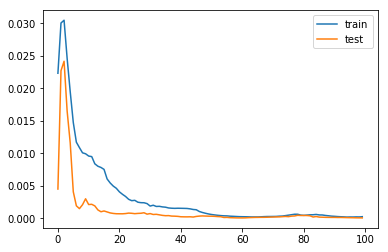

In [1147]:
pyplot.rcParams["figure.figsize"] = default
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Make a prediction

In [0]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

## Invert scaling for forecast

In [0]:
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

## Invert scaling for actual

In [0]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

## Calculate RMSE

In [1151]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 14.565


## Plot prediction

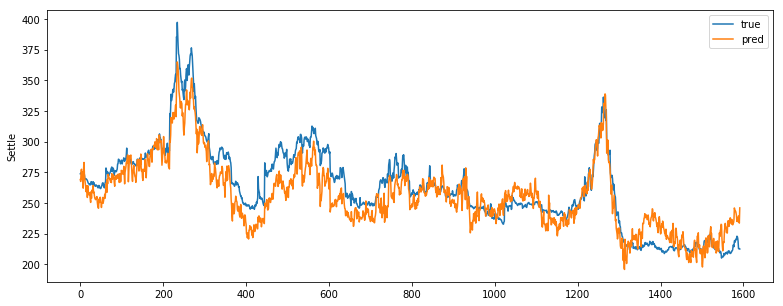

In [1152]:
  # Get the output-signal predicted by the model.
  signal_pred = inv_yhat

  # Get the true output-signal from the data-set.
  signal_true = inv_y

  # Make the plotting-canvas bigger.
  pyplot.figure(figsize=(13,5))

  # Plot and compare the two signals.
  pyplot.plot(signal_true, label='true')
  pyplot.plot(signal_pred, label='pred')

  # Plot labels etc.
  pyplot.ylabel(TARGET_NAME)
  pyplot.legend()
  pyplot.show()

# Extra

## Save model to JSON

In [1153]:
# serialize model to JSON
model_json = model.to_json()
if not os.path.isdir(MODEL_PATH):
    os.makedirs(MODEL_PATH)
with open(MODEL_PATH+"model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(MODEL_PATH+"model.h5")
print("Saved model to disk")

Saved model to disk


## Load json and create model

In [1154]:
# load json and create model
json_file = open(MODEL_PATH+'model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(MODEL_PATH+"model.h5")
print("Loaded model from disk")
loaded_model.summary()

Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 50)                61400     
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 51        
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 2         
Total params: 61,453
Trainable params: 61,453
Non-trainable params: 0
_________________________________________________________________


# License (MIT)

Copyright (c) 2018 by [Marlon Franco]()

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.